# Deterministic slice flows with integer arithmetic

Consider a target density $\pi(x,u)=p(x)1_{[0,1]}(u)$ and let $F$ be the cdf of $p$.
Here the idea is to update a pair $(x,u)$ via
$$
\begin{pmatrix}x\\u\end{pmatrix}=
\begin{pmatrix}
    F^{-1}(\rho(u,x)+\xi\mod 1)\\ 
    \frac{1}{p(x')}((\rho(u,x)+\xi\mod 1)-F(x'))
\end{pmatrix},
$$
where $\rho(u,x)=F(x-1)+up(x)$ converts to proportions and $F(0)=0$ by convention.

We consider a univariate and a bivariate examples, 
both taken from Trevor's ipynb.
First we define all the necessary functions.

In [10]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [72]:
# main functions
def int_update(x,u,prbs,xi=np.pi/16,bigint=1e1,direction='fwd'):
    if direction=='bwd': xi=-xi 
    # integerize
    Mu=int(u*bigint)
    #Mprbs=(prbs*bigint).astype(int)
        
    Mp=int_getp(x,Mu,prbs,xi,bigint)
    xp=Mquantile(Mp,prbs)
    Mup=(Mp-M*cdf(xp-1,prbs))/(M*prbs[xp])
    return xp,Mup
    #return xp,up

def int_getp(x,Mu,prbs,xi=np.pi/16,bigint=1):
    Mp=Mu*prbs[x]
    if x>0:  Mp+=bigint*np.sum(prbs[:x])
    return (Mp+int(bigint*xi))%bigint
    
# auxiliary functions
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)
def Mquantile(Mu,prbs): return np.argmax(np.cumsum(M*prbs)>Mu)
def lcg_update(u,m,a=1.,c=0.): return (a*u+c)%m

## Univariate example

In [73]:
# generate the distribution
np.random.seed(2022)
K=4
prbs=np.random.rand(K)
prbs=np.array([0.047480609696438775, 0.40224879672133207, 0.23127020434512163, 0.31900038923710755]) # trevor's example
prbs=prbs/np.sum(prbs)
prbs

array([0.04748061, 0.4022488 , 0.2312702 , 0.31900039])

In [82]:
# demo
n_iters=1000
verbose = True if n_iters<=10 else False
M=1e8
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
u=np.zeros(n_iters+1)
u[0]=np.random.rand()
u[0]=0.10688645379435302 # trevor's example
u[0]=0.555

# forward map
print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')')
for it in range(n_iters):
    if verbose: print(x[it],u[it])
    tmpx,tmpu=int_update(x[it],u[it],prbs,xi,bigint=M)
    x[it+1]=tmpx
    u[it+1]=tmpu
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')')

Initial (u,x)=(0.555,1)
Final (u,x)=(0.8164326394491539,2)


In [83]:
# backward map
bx=np.zeros(n_iters+1,dtype=int)
bu=np.zeros(n_iters+1)
bu[-1]=u[-1]
bx[-1]=x[-1]
print('Final (u,x)=('+str(bu[-1])+','+str(bx[-1]+1)+')')
for it in range(n_iters):
    tx,tu=update(bx[-(it+1)],bu[-(it+1)],prbs,xi,'bwd')
    bx[-(it+2)]=tx
    bu[-(it+2)]=tu
    if verbose: print(tx,tu)
# end for
print('Initial (u,x)=('+str(bu[0])+','+str(bx[0]+1)+')')

Final (u,x)=(0.8164326394491539,2)
Initial (u,x)=(0.5549382648047289,1)


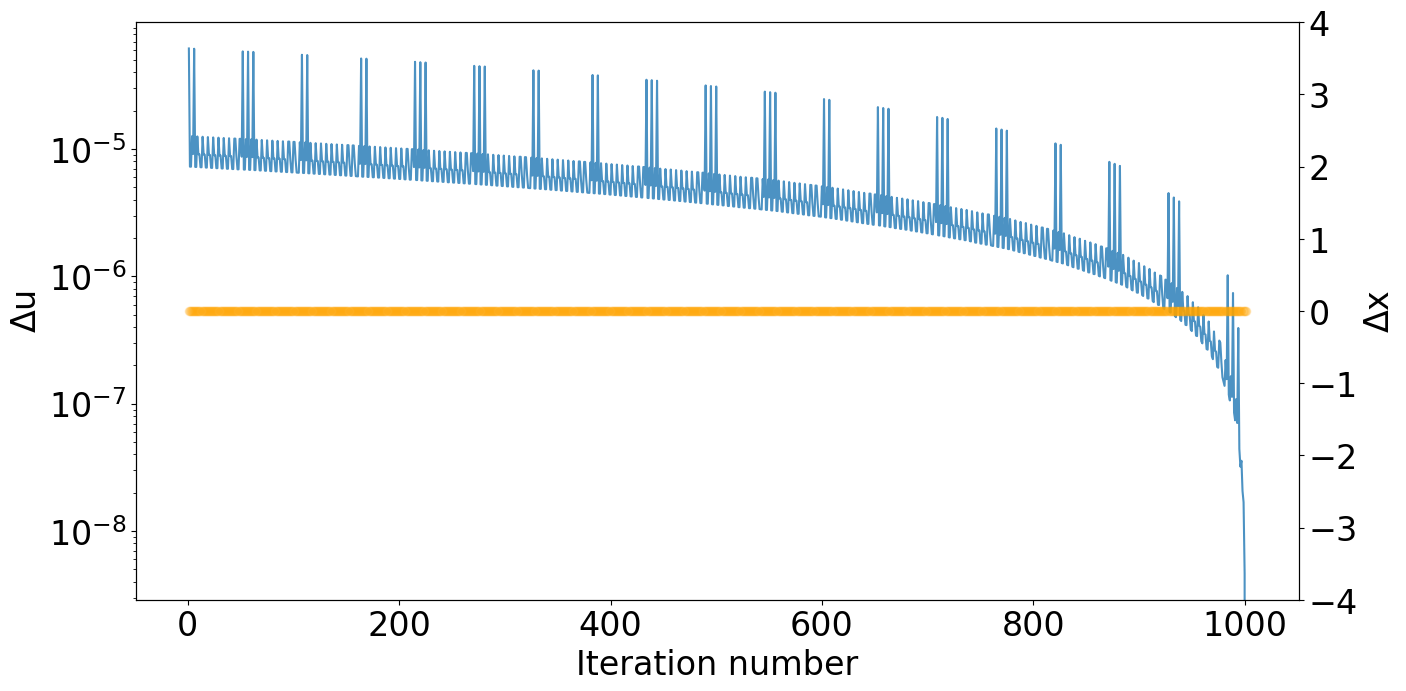

In [84]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1,n_iters+2),np.abs(u-bu),alpha=0.8,label=r'$|u-u_b|$')
ax2.scatter(np.arange(1,n_iters+2),x-bx, alpha=0.2,c='orange',label=r'$x-x_b$')

ax1.set_xlabel('Iteration number')
ax1.set_ylabel(r'$\Delta$u')
#ax1.set_ylim(-4e-14,4e-14)
ax1.set_yscale('log')
ax2.set_ylabel(r'$\Delta$x')
ax2.set_ylim(-prbs.shape[0],prbs.shape[0])

#ax1.legend(frameon=False)
#ax2.legend(loc=[0.8,0.75],frameon=False)
plt.show()